# Projet 2: Analysez des données de systèmes éducatifs
La mission de ce projet consiste à nettoyer et analyser les <a href="https://datacatalog.worldbank.org/search/dataset/0038480">données de la Banque mondiale concernant l'éducation</a>, afin de **réaliser une analyse pré-exploratoire dans l'objectif d'identifier les pays les plus adaptés à un développement commercial**.

Dans ce but, nous avons suivi la démarche ci-après.

**Etape 1 - Nettoyage des données** :
- [prise de connaissance](#pdc_data) du jeu de données ;
- [présélection des indicateurs](#ps_var) ;
- [extraction des données](#extract_data) correspondant aux indicateurs présélectionnés ;
- [examen de la qualité des données de chaque indicateur](#exam_qa) pour sélectionner en conséquence des **indicateurs pertinents** et des **valeurs à retenir** pour l'analyse ;
- [construction d'un indicateur complémentaire](#construc_var) reflétant la **population cible** ;
- [constitution du jeu de données](#construc_data) sur lequel sera basée l'analyse ;
- [constitution d'un jeu de données alternatif](#construc_alt_data) contenant la **projection à 2020** des variables les plus susceptibles d'évolution significative.

**Etape 2 - Analyse des données**:
- [analyse par variable](#analyse_per_var) à l'aide de représentations graphiques, modélisations et seuillage pour le filtrage du jeu de données, afin de produire une liste des pays prioritaires répondant à l'objectif ;
- [analyse combinée de plusieurs variables](#analyse_combo_var) à l'aide de représentations graphiques et seuillages combinés pour le filtrage du jeu de données, afin de produire une liste des pays prioritaires répondant l'objectif ;
- [établissement d'une proposition de score d'attractivité par pays](#construc_score) afin de pouvoir proposer un ordre de priorité de développement tenant compte de l'accessibilité et de la taille du marché, associé à une représentation graphique par zone géographique (régions) permettant d'élaborer des stratégies régionales.
- [examen du score d'attractivité avec le jeu de donnée alternatif et comparaison des résultats](#alt_score).

Ce notebook présente en fin une [conclusion](#conclusion) provisoire à cette étude.

## Moyens utilisés
L'analyse est menée en langage Python, utilisant principalement les **librairies Numpy, Pandas, Matplotlib et Seaborn**.

Le rapport est constitué du présent **Notebook Jupyter** <font color='green'>P2_01_notebook.ipynb</font>, du **support de présentation pour la soutenance** <font color='green'>P2_02_support.pdf</font>, du fichier <font color='green'>P2_03_fonctions.py</font> comprenant les **fonctions utilisées par ce notebook**, du fichier <font color='green'>P2_04_requirements.txt</font> indiquant les **versions des librairies utilisées**, et des **fichiers csv** du sous-répertoire <font color='green'>P2_05_data</font> contenant les fichiers de données de la banque mondiale et les fichiers produits par ce Notebook.

L'étude est menée avec l'IDE PyCharm, python: 3.9.13 et les librairies spécifiées dans le fichier requirements.txt.

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from math import exp

# Import du fichier de fonctions
import P2_03_fonctions as fct

<a id="pdc_data"></a>
# Etape 1: nettoyage des données
## Prise de connaissance du jeu de données
Dans cette section, nous effectuons les opérations suivantes :
- <font color='green'>chargement du jeu de données</font> à partir des fichiers CSV et identification des <font color='green'>principales caractéristiques</font> ;
- identification des <font color='green'>indicateurs</font> (variables) <font color='green'>potentiellement pertinents</font> pour répondre à la problématique ;
- premier examen du contenu et de la <font color='green'>qualité des données</font> sur les <font color='green'>variables présélectionnées</font> et <font color='green'>l'ensemble des individus</font>.

La prise de connaissance s'effectue avec la fonction <font color='green'>discover()</font> du module <font color='green'>P2_03_fonctions.py</font>. Cette fonction:
- **charge le tableau de données** à partir du fichier CSV donné par <font color='green'>url</font> (préciser le caractère de séparation des données s'il est différent de ',' avec l'argument <font color='green'>kwarg *sep*</font>)
- **affiche les informations** suivantes issues des attributs et méthodes de la bibliothèque Pandas, sauf mention contraire stipulée avec un ou plusieurs des <font color='green'>args</font>, respectivement <font color='green'>'no_shape'</font>, <font color='green'>'no_index'</font>, <font color='green'>'no_head'</font>, <font color='green'>'no_dtypes'</font>, <font color='green'>'no_var'</font>, et <font color='green'>'no_desc'</font>: shape, index, head(), dtypes, columns, describe(). Les éléments à afficher ont été sélectionnés pour être les plus pertinents selon le tableau de données.
- **renvoie la matrice contenant le tableau de données**.

Par la suite, les fonctions <font color='green'>missingDataRate()</font> et <font color='green'>missingData()</font> du module <font color='green'>P2_03_fonctions.py</font> donnent des informations générales sur les données manquantes du tableau de données :
- **% global de données manquantes**,
- **Taux de données manquantes par variable** (colonne).
- la **liste des variables sous le seuil de données manquantes** (seuil de 20% par défaut),
- la **liste des individus sous le seuil de données manquantes** (seuil de 20% par défaut).

Enfin, la fonction <font color='green'>duplicatedData()</font> identifie les éventuels **doublons** (lignes).

### Découverte du fichier <font color='green'>EdStatsCountry.csv</font>

Ce tableau de données donne des informations générales sur 241 pays en objet du jeu de données.
Les informations à retirer du premier examen de cette table de donnée (voir ci-dessous) :
- La colonne <font color='green'>Country Code</font> est l'identifiant unique des pays et servira de clé par la suite.
- Les noms de pays à conserver (dans leur forme la plus complète) sont donnés par la colonne <font color='green'>Long Name Code</font>.
- La colonne <font color='green'>Région</font> est potentiellement utile pour structurer une approche technique ou commerciale par région et sera donc conservée.
- La colonne <font color='green'>Income Group</font> caractérise la catégorie de capacité financière de la population et constitue une variable potentiellement pertinente.
- Les autres colonnes ne sont pas potentiellement pertinentes et n'ont pas besoin d'être conservées.

In [2]:
# Chargement des données
dossier = '.\P2_05_data'
fichier = "EdStatsCountry.csv"
EdStatsCountry_data = fct.discover(dossier + "\\" + fichier, 'no_index', 'no_head', 'no_var')

# Informations sur les données manquantes
fct.missingDataRate(EdStatsCountry_data)
#fct.missingData(EdStatsCountry_data, vThr=0.2, iThr=0.1, kVar='Long Name')

# Recherche de doublons selon la clé 'Country Code'
fct.detectDuplicatedData(EdStatsCountry_data, subset='Country Code')

# Mise en place de l'index avec 'Country Code'
EdStatsCountry_data.set_index(keys='Country Code', inplace=True)

Découverte du fichier de données  EdStatsCountry.csv 

Taille du tableau de données:  (241, 32) 

Types de données du tableau :
 Country Code                                          object
Short Name                                            object
Table Name                                            object
Long Name                                             object
2-alpha code                                          object
Currency Unit                                         object
Special Notes                                         object
Region                                                object
Income Group                                          object
WB-2 code                                             object
National accounts base year                           object
National accounts reference year                     float64
SNA price valuation                                   object
Lending category                                      object
Other groups     

### Découverte du fichier <font color='green'>EdStatsData.csv</font>

Ce fichier contient les données relatives aux indicateurs concernant l'éducation pour les 241 pays du jeu de données.
Informations à retirer du premier examen de cette table de donnée (voir ci-dessous) :

- Un **tableau de données de taille importante** (886 930 lignes pour 70 colonnes).
- Les colonnes <font color='green'>Country Code</font> et <font color='green'>Indicator Code</font> sont des **identifiants uniques**, le premier concernant les **pays** et le second concernant les **indicateurs d'éducation** ; ils serviront de clé par la suite.
- Les 66 dernières colonnes contiennent les valeurs annuelles des indicateurs, de 1970 à 2100. Pour la mission assignée, seules les années les plus récentes présentent de l'intérêt. Par ailleurs, ces colonnes contiennent une proportion très importante de manquants (plus de 80%). Cela signifie qu'**une majorité d'indicateurs n'est pas renseignée** et il faudra donc en tenir compte pour la présélection des indicateurs pertinents. S'agissant de la période de temps d'observation, nous retiendrons par prudence à ce stade les 10 dernières années pour lesquelles les indicateurs sont renseignés (2006-2015), afin de sélectionner ultérieurement l'**année la plus récente et avec le meilleur taux de remplissage pour les indicateurs qui seront présélectionnés**.


In [3]:
# Chargement des données
fichier = "EdStatsData.csv"
EdStatsData = fct.discover(dossier + "\\" + fichier, 'no_index', 'no_head', 'no_var', 'no_dtypes', 'no_desc')

# Informations sur les données manquantes
#fct.missingDataRate(EdStatsData)
fct.missingData(EdStatsData, vThr=0.9, iThr=0.25, kVar='Country Name')

# Recherche de doublons
fct.detectDuplicatedData(EdStatsData)

Découverte du fichier de données  EdStatsData.csv 

Taille du tableau de données:  (886930, 70) 

25 sur 70 variables avec moins de 90% de manquants : 
- Country Name
- Country Code
- Indicator Name
- Indicator Code
- 1980
- 1985
- 1990
- 1995
- 1999
- 2000
- 2001
- 2002
- 2003
- 2004
- 2005
- 2006
- 2007
- 2008
- 2009
- 2010
- 2011
- 2012
- 2013
- 2014
- 2015

0 sur 886930 individus avec moins de 25% de manquants : 

Nombre de doublons:  0 



### Découverte du fichier <font color='green'>EdStatsSeries.csv</font>

Ce fichier contient les 3665 indicateurs relatifs à l'éducation.
Les **indicateurs** sont décrit principalement par 6 colonnes :
- La colonne <font color='green'>Series Code</font> est l'**identifiant unique de chaque indicateur** : il servira de clé par la suite.
- Le **thème auquel appartient l'indicateur** (voir la liste sur le site <a href="https://datatopics.worldbank.org/education/indicators">https://datatopics.worldbank.org/education/indicators</a>).
- Le **nom de l'indicateur**, sa **définition courte** et **définition longue**.
- La **source des données** de chaque indicateur.

Les autres colonnes sont peu renseignées et donc difficilement exploitables.

Les informations que nous conserverons pour le jeu de données servant à l'analyse concerneront l'**identifiant et le nom de chaque indicateur**. Pour mémoire, la définition et l'ensemble des informations relative à un identifiant d'indicateur peuvent être trouvés sur l'onglet <a href="https://databank.worldbank.org/metadataglossary/jobs/series/">Metadata Glossary</a> du site.

In [4]:
# Chargement des données
fichier = "EdStatsSeries.csv"
EdStatsSeriesData = fct.discover(dossier + "\\" + fichier, 'no_index', 'no_head', 'no_dtypes', 'no_desc')

# Informations sur les données manquantes
fct.missingDataRate(EdStatsSeriesData)
#fct.missingData(EdStatsSeriesData, vThr=0.8, iThr=0.5, kVar='Series Code')

# Recherche de doublons selon la clé 'Series Code'
fct.detectDuplicatedData(EdStatsSeriesData, subset='Series Code')

Découverte du fichier de données  EdStatsSeries.csv 

Taille du tableau de données:  (3665, 21) 

Liste des variables :
 -  Series Code
 -  Topic
 -  Indicator Name
 -  Short definition
 -  Long definition
 -  Unit of measure
 -  Periodicity
 -  Base Period
 -  Other notes
 -  Aggregation method
 -  Limitations and exceptions
 -  Notes from original source
 -  General comments
 -  Source
 -  Statistical concept and methodology
 -  Development relevance
 -  Related source links
 -  Other web links
 -  Related indicators
 -  License Type
 -  Unnamed: 20


% de données manquantes par variable : 
                                        0
Series Code                           0%
Topic                                 0%
Indicator Name                        0%
Short definition                     41%
Long definition                       0%
Unit of measure                     100%
Periodicity                          97%
Base Period                          91%
Other notes                   

### Découverte du fichier <font color='green'>EdStatsCountry-Series.csv</font>

Ce fichier contient **613 précisions résultant du croisement des pays** avec **deux types d'indicateurs**: des informations de **population** (totale et croissance) et de **PIB**.
**Seules les informations sur le PIB seront utilisées par la suite, et ce tableau nous apprend que ces informations résultent d'estimations basées sur des régressions.**
Ce tableau ne sera pas exploité par la suite.

In [5]:
# Chargement des données
fichier = "EdStatsCountry-Series.csv"
EdStatsCountrySeriesData = fct.discover(dossier + "\\" + fichier, 'no_index', 'no_dtypes', 'no_desc')

# Informations sur les données manquantes
fct.missingDataRate(EdStatsCountrySeriesData)
#fct.missingData(EdStatsCountrySeriesData, vThr=0.0, iThr=0.0)

# Recherche de doublons
fct.detectDuplicatedData(EdStatsCountrySeriesData)

Découverte du fichier de données  EdStatsCountry-Series.csv 

Taille du tableau de données:  (613, 4) 

Variables et premières lignes du tableau de données:

   CountryCode         SeriesCode  \
0         ABW        SP.POP.TOTL   
1         ABW        SP.POP.GROW   
2         AFG        SP.POP.GROW   
3         AFG  NY.GDP.PCAP.PP.CD   
4         AFG        SP.POP.TOTL   

                                         DESCRIPTION  Unnamed: 3  
0  Data sources : United Nations World Population...         NaN  
1  Data sources: United Nations World Population ...         NaN  
2  Data sources: United Nations World Population ...         NaN  
3                 Estimates are based on regression.         NaN  
4  Data sources : United Nations World Population...         NaN   

Liste des variables :
 -  CountryCode
 -  SeriesCode
 -  DESCRIPTION
 -  Unnamed: 3


% de données manquantes par variable : 
                0
CountryCode   0%
SeriesCode    0%
DESCRIPTION   0%
Unnamed: 3  100% 


Nombr

### Découverte du fichier <font color='green'>EdStatsFootNote.csv</font>

Ce fichier contient 643 638 précisions relatives à certains indicateurs pour certains pays.
Ce tableau ne sera pas exploité par la suite.


In [6]:
# Chargement des données
fichier = "EdStatsFootNote.csv"
EdStatsFootNoteData = fct.discover(dossier + "\\" + fichier, 'no_index', 'no_head', 'no_dtypes', 'no_desc')

# Informations sur les données manquantes
fct.missingDataRate(EdStatsFootNoteData)
#fct.missingData(EdStatsFootNoteData, vThr=0.05, iThr=0.05)

# Recherche de doublons
fct.detectDuplicatedData(EdStatsFootNoteData)

Découverte du fichier de données  EdStatsFootNote.csv 

Taille du tableau de données:  (643638, 5) 

Liste des variables :
 -  CountryCode
 -  SeriesCode
 -  Year
 -  DESCRIPTION
 -  Unnamed: 4


% de données manquantes par variable : 
                0
CountryCode   0%
SeriesCode    0%
Year          0%
DESCRIPTION   0%
Unnamed: 4  100% 


Nombre de doublons:  0 



<a id="ps_var"></a>
## Présélection des indicateurs
L'objet de la mission étant de lister les pays cibles, les premières variables concernent l'**identification de ces pays** (<font color='green'>Country Code</font>), associé au **nom en clair de ces pays** (<font color='green'>Country Name</font>).
Les autres variables concernent les indicateurs de <font color='green'>EdStatsSeries.csv</font> présélectionnés ci-après, en objet de cette section. Enfin, les valeurs de ces indicateurs seront déterminées en fonction de l'année, à sélectionner entre 2011 et 2015, qui optimise les critères d'être la plus récente et de fournir un maximum de valeurs pour les indicateurs présélectionnés.

Le service commercialisé étant de la formation à distance, il nécessite une capacité d'accès à internet ainsi qu'un minimum d'engouement de la population à l'utiliser. L'indicateur permettant de répondre à ce besoin est <font color='green'>IT.NET.USER.P2</font>, qui indique le **% d'utilisateurs d'internet** et renseigne par conséquent sur l'accès à internet et sa popularité.

S'agissant d'une offre de formation continue, les étudiants potentiels d'une telle offre de formation se trouvent dans la population ayant terminé un niveau 3 d'éducation (études secondaires jusqu'au bac). Cette population est caractérisée par 2 familles d'indicateurs:
- <font color='green'>BAR.POP.I</font>: identifie le **volume de population en millier pour la tranche d'âge I** considérée (I = 2024, 2529, 3034, 3539, 4044, 4549, 5054, 5559).
- <font color='green'>BAR.SEC.CMPT.I.ZS</font>: identifie le **% de population ayant terminé ses études secondaires pour la tranche d'âge I** considérée.

Le produit de ces 2 indicateurs donne en conséquence le **volume de population ayant terminé ses études secondaires**.
S'agissant des tranches d'âges à considérer, nous examinerons toutes les tranches de 20 à 59 ans, mais en accordant une pondération différente selon les tranches d'âges afin d'obtenir un résultat reflétant la priorité accordée à la formation par chaque tranche d'âges. Nous constituerons ainsi un indicateur résultant reflétant le volume total de population cible:
<font color='green'>BAR.POP.SEC.TOT</font> = $\sum \limits _{I=2024}^{5559} \text{Coef.I * BAR.POP.I * BAR.SEC.CMPT.I.ZS}$
La matrice Coef.I est à décider avec le board de l'entreprise afin de refléter sa stratégie de ciblage des étudiants. Pour cette mission, nous allons nous inspirer de la répartition des ages d'un échantillon de 76 personnes qui se sont présentées sur workplace en même temps que moi :

| <font size="3">Tranches ages</font> | <font size="3">Nb personnes</font> | <font size="3">Coef.I proposé</font> |
|:-----------------------------------:|:------------:|:------------------------------------:|
|     <font size="3">2024</font>      |      <font size="3">22</font>      |      <font size="3">100%</font>      |
|     <font size="3">2529</font>      |      <font size="3">27</font>      |      <font size="3">100%</font>      |
|     <font size="3">3034</font>      |      <font size="3">11</font>      |      <font size="3">50%</font>       |
|     <font size="3">3539</font>      |      <font size="3">4</font>       |      <font size="3">25%</font>       |
|     <font size="3">4044</font>      |      <font size="3">11</font>      |      <font size="3">50%</font>       |
|     <font size="3">4549</font>      |      <font size="3">0</font>       |      <font size="3">10%</font>       |
|     <font size="3">5054</font>      |      <font size="3">0</font>       |       <font size="3">5%</font>       |
|     <font size="3">5559</font>      |      <font size="3">1</font>       |      <font size="3">2.5%</font>      |

*__Note__ : cette répartition non uniforme représente à la fois le **besoin** et la **volonté** de formation des étudiants: volonté estimée décroissante avec l'age et besoin estimé avec 2 pics, un premier pic entre 20 et 30 ans (orientation initiale et complément de formation) et un second pic entre 40 et 45 ans (reconversion).*

Par ailleurs, la capacité de la population cible à suivre une formation en français ou en anglais faciliterait l'accès de l'entreprise au marché. Plusieurs niveaux de priorités pourraient ainsi être attribués :
- Priorité 1: francophone, indicateur <font color='green'>LO.PASEC.FRE5.HIG</font>
- Priorité 2: compréhension de l'anglais, indicateur <font color='green'>LO.EGRA.READ.ENG.ADV.3GRD</font>
- Priorité 3: autres langues

Cette approche serait bien entendu à valider par le board en fonction de la stratégie de l'entreprise.

S'agissant du financement de la formation, les financeurs potentiels sont: les étudiants eux-mêmes (la population concernée du pays), le gouvernement (plus largement les autorités publiques) et les entreprises. Les indicateurs présélectionnés pour estimer cette capacité sont :
- <font color='green'>NY.GDP.MKTP.PP.CD</font>: PIB à parité de pouvoir d'achat en dollar international courant, indique la capacité de pouvoir d'achat du pays, relativement aux autres pays.
- <font color='green'>UIS.XGOVEXP.IMF.3</font>: dépenses publiques pour l'éducation au-delà du secondaire en % du total des dépenses publiques, caractérise la priorité donnée par le gouvernement à l'éducation post-secondaire.
- <font color='green'>NY.GDP.PCAP.PP.CD</font>: PIB par habitant en dollar courant, indique la capacité de pouvoir d'achat de la population, relativement aux populations des autres pays ; cet indicateur se rapproche de l'indicateur suivant.
- <font color='green'>Income Group</font> identifié lors de l'examen du fichier EdStatsCountry.csv, qui catégorise la capacité financière de la population, et qui pourra être éventuellement utilisé en complément.



<a id="extract_data"></a>
## Extraction des données de <font color='green'>EdStatsSeries.csv</font> correspondant aux indicateurs présélectionnés
Nous extrayons ci-après de <font color='green'>EdStatsData</font> la liste des indicateurs préselectionnés (<font color='green'>listeIndicateurs</font>) pour les années **2006 à 2020**. Puis, nous examinons le taux de manquant afin de se faire une première idée de l'année avec le meilleur taux de remplissage :
- l'**année 2010** apparait globalement au double de taux de remplissage par rapport aux autres ;
- le **taux de remplissage avant 2010 n'est pas meilleur que celui après 2010** ;
- le taux de manquants après 2016 est de 100%.

Nous pouvons déjà **éliminer les années après 2016, et celles avant 2010**, ces dernières n'offrant pas de meilleure qualité et ayant l'inconvénient d'être plus anciennes.
Par ailleurs, même si l'année 2010 parait de loin la meilleure, compte tenu de son taux élevé (43%) de manquants, nous devons examiner plus avant la **qualité des données pour chaque indicateur de 2010 à 2016**, afin d'envisager un choix hybride avec des valeurs correspondant à des années différentes selon les types d'indicateurs. Cela fera l'objet de la section suivante et sera effectué à partir des données <font color='green'>EdStatsData_preselected</font>.

In [7]:
# Liste des indicateurs présélectionnés
listeIndicateurs = ["IT.NET.USER.P2", "LO.PASEC.FRE5.HIG", "LO.EGRA.READ.ENG.ADV.3GRD",
                    "NY.GDP.MKTP.PP.CD", "UIS.XGOVEXP.IMF.3", "NY.GDP.PCAP.PP.CD",
                    "BAR.POP.2024", "BAR.POP.2529", "BAR.POP.3034", "BAR.POP.3539",
                    "BAR.POP.4044", "BAR.POP.4549", "BAR.POP.5054", "BAR.POP.5559",
                    "BAR.SEC.CMPT.2024.ZS", "BAR.SEC.CMPT.2529.ZS", "BAR.SEC.CMPT.3034.ZS", "BAR.SEC.CMPT.3539.ZS",
                    "BAR.SEC.CMPT.4044.ZS", "BAR.SEC.CMPT.4549.ZS", "BAR.SEC.CMPT.5054.ZS", "BAR.SEC.CMPT.5559.ZS"]
# Extraction des lignes de "EdStatsData" qui correspondent aux indicateurs présélectionnés
EdStatsData_subset = EdStatsData[EdStatsData["Indicator Code"].isin(listeIndicateurs)].reset_index()
#EdStatsData_subset.to_csv(dossier + "\\" + "EdStatsData_subset_xl.csv", sep=';')
# Extraction des colonnes pour les années à investiguer
EdStatsData_preselected = EdStatsData_subset[["Country Code", "Indicator Code", "2006", "2007",
                                              "2008","2009","2010","2011","2012","2013","2014","2015","2016", "2017", "2020"]]
EdStatsData_preselected.to_csv(dossier + "\\" + "EdStatsData_preselected.csv", sep=',', index=False)
EdStatsData_preselected.to_csv(dossier + "\\" + "EdStatsData_preselected_xl.csv", sep=';', index=False)
# Détermination du taux de données manquantes par année pour l'ensemble des indicateurs
fct.missingDataRate(EdStatsData_preselected)

% de données manquantes par variable : 
                   0
Country Code     0%
Indicator Code   0%
2006            87%
2007            87%
2008            86%
2009            86%
2010            43%
2011            86%
2012            86%
2013            87%
2014            87%
2015            88%
2016            88%
2017           100%
2020           100% 



<a id="exam_qa"></a>
## Construction de tables pivot pour les années 2010 à 2016 afin d'examiner de la qualité des données de chaque indicateur
Pour chaque indicateur et pour chaque année de 2010 à 2016, nous calculons le taux de manquant.
Nous pouvons en tirer les conclusions suivantes:
- L'année 2010 est la seule année exploitable concernant les 16 indicateurs de population (qui nous serviront à calculer l'indicateur <font color='green'>BAR.POP.SEC.TOT</font>). Le taux de manquants est néanmoins de 40%, ce qui réduit considérablement la visibilité sur les pays cibles, et fera l'objet d'une analyse complémentaire dans la section suivante.
- Avec un taux de manquants de 6% à 8%, l'indicateur <font color='green'>IT.NET.USER.P2</font> apparait de bonne qualité pour toutes les années. Nous choisirons en conséquence l'année 2016 car la plus récente.
- Les indicateurs <font color='green'>LO.PASEC.FRE5.HIG</font> et <font color='green'>LO.EGRA.READ.ENG.ADV.3GRD</font> ont près de 100% de manquants et ne sont donc pas exploitable. Si une stratégie de priorisation linguistique devait être décidée, elle nécessiterait d'aller rechercher des données par ailleurs. Pour cette mission, nous n'irons pas plus loin sur ce thème.
- Les données de PIB (<font color='green'>NY.GDP.MKTP.PP.CD</font>) et PIB par habitant (<font color='green'>NY.GDP.PCAP.PP.CD</font>) ont des taux de manquant de 11% à 16%, ce qui en fait des indicateurs exploitables. Nous utiliserons donc le plus récent, celui de 2016.
- Avec un taux de manquant supérieur à 66%, l'indicateur <font color='green'>UIS.XGOVEXP.IMF.3</font> (taux de dépenses publiques pour l'éducation au-delà du secondaire) n'est pas exploitable et ne sera pas utilisé plus avant pour cette mission.

In [8]:
# Examen de la qualité des indicateurs de 2006 à 2016
liste = ["2010", "2011", "2012", "2013", "2014", "2015", "2016"]
pd.options.mode.chained_assignment = None
fct.missingData4listCol(EdStatsData_preselected, liste)

# Indicateurs pour 2010
data2010 = EdStatsData_preselected[["Country Code", "Indicator Code", "2010"]]
dataSorted2010 = data2010.sort_values(by=["Country Code", "Indicator Code"])
dataReshaped2010 = dataSorted2010.pivot(index="Country Code", columns="Indicator Code", values="2010")

# Indicateurs pour 2016
data2016 = EdStatsData_preselected[["Country Code", "Indicator Code", "2016"]]
dataSorted2016 = data2016.sort_values(by=["Country Code", "Indicator Code"])
dataReshaped2016 = dataSorted2016.pivot(index="Country Code", columns="Indicator Code", values="2016")

% de données manquantes par indicateur: 
                            2010  2011  2012  2013  2014  2015  2016
Indicator Code                                                     
BAR.POP.2024                40%  100%  100%  100%  100%  100%  100%
BAR.POP.2529                40%  100%  100%  100%  100%  100%  100%
BAR.POP.3034                40%  100%  100%  100%  100%  100%  100%
BAR.POP.3539                40%  100%  100%  100%  100%  100%  100%
BAR.POP.4044                40%  100%  100%  100%  100%  100%  100%
BAR.POP.4549                40%  100%  100%  100%  100%  100%  100%
BAR.POP.5054                40%  100%  100%  100%  100%  100%  100%
BAR.POP.5559                40%  100%  100%  100%  100%  100%  100%
BAR.SEC.CMPT.2024.ZS        40%  100%  100%  100%  100%  100%  100%
BAR.SEC.CMPT.2529.ZS        40%  100%  100%  100%  100%  100%  100%
BAR.SEC.CMPT.3034.ZS        40%  100%  100%  100%  100%  100%  100%
BAR.SEC.CMPT.3539.ZS        40%  100%  100%  100%  100%  100%  100%
BAR.SE

<a id="construc_var"></a>
## Construction de l'indicateur de population <font color='green'>BAR.POP.SEC.TOT</font>
L'ensemble des données de population cible (en milliers) sont placées dans le DataFrame <font color='green'>dataPOP</font>:
- en index les noms de code des **pays** ;
- en colonne la **population par tranche d'age** (proratisée avec le produit <font color='green'>Coef.I</font> * <font color='green'>BAR.SEC.CMPT.I.ZS</font>) ;
- la colonne de l'indicateur <font color='green'>BAR.POP.SEC.TOT</font> indiquant la **population cible totale** (somme des colonnes précédentes).
- deux colonnes supplémentaires importées de <font color='green'>EdStatsCountry_data</font> pour préciser le pays (<font color='green'>Table Name</font>) et la région (<font color='green'>Region</font>

Par ailleurs, une version clean de ce DataFrame, <font color='green'>dataPOPclean</font>, est obtenue de <font color='green'>dataPOP</font> en supprimant les lignes non renseignées (NaN) et en triant les lignes selon 2 clés:
- une première clé par région ;
- une seconde clé par valeur décroissante de l'indicateur de population cible <font color='green'>BAR.SEC.CMPT.I.ZS</font>.

C'est ce DataFrame qui est affiché en sortie du traitement et fait l'objet d'un enregistrement dans le fichier <font color='green'>dataPOPclean.csv</font>.

In [9]:
# On place BAR.SEC.CMPT.I.ZS dans un DataFrame pour préparer le produit matriciel
dataBarSec = pd.DataFrame([])
# On conserve l'indexage avec les CodePays
dataBarSec.index = dataReshaped2010.index
dataBarSec = dataReshaped2010[["BAR.SEC.CMPT.2024.ZS", "BAR.SEC.CMPT.2529.ZS",
                               "BAR.SEC.CMPT.3034.ZS", "BAR.SEC.CMPT.3539.ZS",
                               "BAR.SEC.CMPT.4044.ZS", "BAR.SEC.CMPT.4549.ZS",
                               "BAR.SEC.CMPT.5054.ZS", "BAR.SEC.CMPT.5559.ZS"]]
# On renomme les colonnes en vue du produit matriciel
# Suppression du warning non applicable
dataBarSec.rename(columns={"BAR.SEC.CMPT.2024.ZS": "2024","BAR.SEC.CMPT.2529.ZS": "2529",
                                        "BAR.SEC.CMPT.3034.ZS": "3034", "BAR.SEC.CMPT.3539.ZS": "3539",
                                        "BAR.SEC.CMPT.4044.ZS": "4044", "BAR.SEC.CMPT.4549.ZS": "4549",
                                        "BAR.SEC.CMPT.5054.ZS": "5054", "BAR.SEC.CMPT.5559.ZS": "5559"}, inplace=True)
#print("\ndataBarSec : \n", dataBarSec.head(),"\n")
#dataBarSec.to_csv(dossier + "\\" + "dataBarSec_xl.csv", sep=';')

# Fixation de la matrice de coefficients Coef.I
coef = np.array([1.000, 1.000, 0.500, 0.250, 0.500, 0.100, 0.050, 0.025])

# Calcul du % de population cible résultant du produit de Coef.I * BAR.SEC.CMPT.I.ZS
coef = coef / 100
dataPCpop = dataBarSec.mul(coef, axis=1)
#print("% de population : \n", dataPCpop, '\n')
#dataPCpop.to_csv(dossier + "\\" + "dataPCpop_xl.csv", sep=';')

# On place BAR.POP.I dans un DataFrame pour préparer le produit matriciel (idem BAR.SEC.CMPT.I.ZS)
dataBarPop = pd.DataFrame([])
dataBarPop.index = dataReshaped2010.index
dataBarPop = dataReshaped2010[["BAR.POP.2024", "BAR.POP.2529", "BAR.POP.3034", "BAR.POP.3539",
                               "BAR.POP.4044", "BAR.POP.4549", "BAR.POP.5054", "BAR.POP.5559"]]
dataBarPop.rename(columns={"BAR.POP.2024": "2024","BAR.POP.2529": "2529",
                           "BAR.POP.3034": "3034", "BAR.POP.3539": "3539",
                           "BAR.POP.4044": "4044", "BAR.POP.4549": "4549",
                           "BAR.POP.5054": "5054", "BAR.POP.5559": "5559"}, inplace=True)
# print("\ndataBarPop : \n", dataBarPop.head(),"\n")
#dataBarPop.to_csv(dossier + "\\" + "dataBarPop_xl.csv", sep=';')

# Produit matriciel: cible (en %) * volume de population
dataPOP = dataPCpop.mul(dataBarPop, axis=1)
#print("Résultat : \n", dataPOP, '\n')
#dataPOP.to_csv(dossier + "\\" + "dataPOP_xl.csv", sep=';')
# Calcul de l'indicateur BAR.POP.SEC.TOT que l'on place dans une nouvelle colonne de dataPOP
# L'argument min_count=1 conduit à affecter un résultat NaN lorsqu'au moins 1 NaN est rencontré sur la ligne
dataPOP["BAR.POP.SEC.TOT"] = dataPOP.sum(axis=1, min_count=1)

# Ajout des colonnes de nom de pays et de région
dataPOP["Pays"] = EdStatsCountry_data["Table Name"]
dataPOP["Region"] = EdStatsCountry_data["Region"]

# Etablissement d'une version clean et structurée pour affichage du résultat
dataPOPclean = dataPOP.dropna()
dataPOPclean.sort_values(by=["Region", "BAR.POP.SEC.TOT"], ascending=(True, False), inplace=True)

# Affichage du résultat
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("DataFrame dataPOPclean : \n", dataPOPclean, '\n')

#dataPOPclean.to_csv(dossier + "\\" + "dataPOPclean_xl.csv", sep=';')

DataFrame dataPOPclean : 
 Indicator Code   2024   2529   3034  3539   4044  4549  5054  5559  \
Country Code                                                         
CHN            40,215 28,803 12,702 5,743 11,988 2,228   882   222   
IDN             8,676  6,488  2,699 1,122  2,058   205    89    24   
JPN             3,103  2,654  1,589 1,044  1,835   370   176    98   
VNM             3,004  1,996    698   314    611   108    29    11   
PHL             2,152  1,928    927   407    703    91    38    12   
...               ...    ...    ...   ...    ...   ...   ...   ...   
LSO                52     40      8     2      3     0     0     0   
MRT                46     32     11     4      7     1     0     0   
COG                17     14      8     5     11     2     1     0   
SWZ                13      8      1     0      0     0     0     0   
GMB                 8      6      3     1      1     0     0     0   

Indicator Code  BAR.POP.SEC.TOT         Pays               Reg

## Analyse des indicateurs de PIB <font color='green'>NY.GDP.MKTP.PP.CD</font> et PIB par habitant <font color='green'>NY.GDP.PCAP.PP.CD</font>
Les données relatives au PIB sont placées dans le DataFrame <font color='green'>dataPIB</font>:
- en index les noms de code des **pays** ;
- en colonne les 2 indicateurs <font color='green'>NY.GDP.MKTP.PP.CD</font> et  <font color='green'>NY.GDP.PCAP.PP.CD</font> ;
- trois colonnes supplémentaires importées de <font color='green'>EdStatsCountry_data</font> pour préciser le pays (<font color='green'>Table Name</font>), la région (<font color='green'>Region</font>) et le niveau de revenus (<font color='green'>Income Group</font>).

Par ailleurs, une version clean de ce DataFrame, <font color='green'>dataPIBclean</font>, est obtenue de <font color='green'>dataPIB</font> en supprimant les lignes non renseignées (NaN) et en triant les lignes selon 2 clés:
- une première clé par région ;
- une seconde clé par valeur décroissante de l'indicateur de PIB par habitant (<font color='green'>NY.GDP.PCAP.PP.CD</font>).

C'est ce DataFrame qui est affiché en sortie du traitement et fait l'objet d'un enregistrement dans le fichier <font color='green'>dataPIBclean.csv</font>.

L'examen du fichier résultat montre une forte cohérence entre les indicateurs <font color='green'>NY.GDP.PCAP.PP.CD</font> et <font color='green'>Income Group</font>, ce qui conforte la qualité du résultat.
En conclusion, l'indicateur <font color='green'>NY.GDP.PCAP.PP.CD</font> sera retenu en priorité dans le cadre de cette mission.

In [10]:
# On place les indicateurs dans un DataFrame en vue de leur analyse
dataPIB = pd.DataFrame([])
# On conserve l'indexage avec les CodePays
dataPIB.index = dataReshaped2016.index
# On ajoute les colonnes des 2 indicateurs
dataPIB = dataReshaped2016[["NY.GDP.MKTP.PP.CD", "NY.GDP.PCAP.PP.CD"]]
#print("\ndataPIB : \n", dataPIB.head(),"\n")
#dataPIB.to_csv(dossier + "\\" + "dataPIB_xl.csv", sep=';')

# On ajoute les colonnes de nom de "Pays", "Region" et "Income group"
#dataPIB.loc['Country Code', "Table Name"] = EdStatsCountry_data["Table Name"]
dataPIB["Pays"] = EdStatsCountry_data["Table Name"]
dataPIB["Region"] = EdStatsCountry_data["Region"]
dataPIB["Income Group"] = EdStatsCountry_data["Income Group"]

# Production d'une version clean structurée pour affichage du résultat
dataPIBclean = dataPIB.dropna()
dataPIBclean.sort_values(by=["Region", "NY.GDP.PCAP.PP.CD"], ascending=(True, False), inplace=True)

# Affichage du résultat
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("DataFrame dataPIBclean : \n", dataPIBclean, '\n')

#dataPIBclean.to_csv(dossier + "\\" + "dataPIBclean_xl.csv", sep=';')

DataFrame dataPIBclean : 
 Indicator Code  NY.GDP.MKTP.PP.CD  NY.GDP.PCAP.PP.CD  \
Country Code                                           
MAC                63,875,743,142            104,344   
SGP               493,458,283,650             88,003   
BRN                32,827,699,653             77,571   
HKG               430,891,489,629             58,651   
AUS             1,128,908,014,064             46,790   
...                           ...                ...   
NER                20,427,423,424                988   
LBR                 3,756,812,855                814   
COD                63,288,929,824                804   
BDI                 8,201,052,195                779   
CAF                 3,216,524,544                700   

Indicator Code                      Pays               Region  \
Country Code                                                    
MAC                     Macao SAR, China  East Asia & Pacific   
SGP                            Singapore  East As

<a id="construc_data"></a>
## Constitution du jeu de données à analyser
Le jeu de donnée retenu est constitué de :
- L'index de **nom de code des pays** ;
- Les **noms de pays** (<font color='green'>Pays</font>) ;
- Les **régions** auxquelles appartiennent les pays (<font color='green'>Region</font>) ;
- La **population cible** (<font color='green'>Population cible</font> = <font color='green'>BAR.POP.SEC.TOT</font>), à partir des données de 2010 ;
- Le **PIB par habitant** (<font color='green'>PIB par habitant</font> = <font color='green'>NY.GDP.PCAP.PP.CD</font>) à partir des données de 2016 ;
- Le **% d'utilisateurs d'internet** (<font color='green'>Internet</font> = <font color='green'>IT.NET.USER.P2</font>), à partir des données de 2016.

Nous constituons le Dataframe <font color='green'>dataMission</font> contenant ces données pour les pays pour lesquels elles sont renseignées, comme base à l'analyse en objet de la seconde étape de cette mission.



In [11]:
# Jeu de données dataMission
# On place l'indicateur dans un DataFrame en vue de leur analyse
dataMission = pd.DataFrame([])
# On conserve l'indexage avec les CodePays
dataMission.index = dataReshaped2016.index
# On place les colonnes des 2 indicateurs dans dataMission
dataMission = dataReshaped2016[["IT.NET.USER.P2"]]
dataMission.rename(columns={"IT.NET.USER.P2": "Internet"}, inplace=True)

# On ajoute les colonnes de nom de "Pays", "Region"
#dataPIB.loc['Country Code', "Table Name"] = EdStatsCountry_data["Table Name"]
dataMission["Pays"] = EdStatsCountry_data["Table Name"]
dataMission["Region"] = EdStatsCountry_data["Region"]

# On ajoute la colonne BAR.POP.SEC.TOT dataPOP et la colonne NY.GDP.PCAP.PP.CD de dataPIB
dataMission["Population cible"] = dataPOP["BAR.POP.SEC.TOT"]
dataMission["PIB par habitant"] = dataPIB["NY.GDP.PCAP.PP.CD"]
#print(dataMission)

# Production d'une version clean structurée pour affichage du résultat
dataMission = dataMission.dropna()
dataMission = dataMission[["Region", "Pays", "Internet", "Population cible", "PIB par habitant"]]
dataMission.sort_values(by=["Region", "Population cible"], ascending=(True, False), inplace=True)

# Affichage et enregistrement (CSV) du résultat
print("Taille du jeu de données (pays, variables) :", dataMission.shape, '\n')
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("DataFrame dataMission : \n", dataMission, '\n')
dataMission.to_csv(dossier + "\\" + "dataMission.csv", sep=',')
dataMission.to_csv(dossier + "\\" + "dataMission_xl.csv", sep=';')

Taille du jeu de données (pays, variables) : (139, 5) 

DataFrame dataMission : 
 Indicator Code               Region         Pays  Internet  Population cible  \
Country Code                                                                   
CHN             East Asia & Pacific        China        53           102,784   
IDN             East Asia & Pacific    Indonesia        25            21,360   
JPN             East Asia & Pacific        Japan        92            10,870   
VNM             East Asia & Pacific      Vietnam        46             6,773   
PHL             East Asia & Pacific  Philippines        56             6,257   
...                             ...          ...       ...               ...   
LSO              Sub-Saharan Africa      Lesotho        27               105   
MRT              Sub-Saharan Africa   Mauritania        18               101   
COG              Sub-Saharan Africa  Congo, Rep.         8                58   
SWZ              Sub-Saharan Africa   

<a id="construc_alt_data"></a>
## Constitution du jeu de données alternatif basé sur des projections
Nous pouvons envisager par ailleurs de **projeter certaines données afin d'examiner l'effet de leur actualisation prospective sur le résultat de l'analyse**.
Pour cette mission, nous l'effectuons sur les paramètres dont les évolutions semblent les plus sensibles : le **PIB par habitant** et le **% d'utilisateurs d'internet**. Dans ce but, nous utilisons la fonction <font color='green'>polyPredict</font> (fichier Python *fonctions*), qui effectue une projection avec un polynôme de régression (méthode des moindres carrés). Après plusieurs essais, et afin de limiter le risque de volatilité trop importante des données, nous nous limiterons pour le moment au degré 1 (régression linéaire). Pour une projection significative tout en conservant malgré cela une certaine fiabilité, nous visons une **projection sur l'année 2020**. En examinant les résultats des projections pour 2018 et 2020, nous pouvons conclure à la faisabilité de cette approche, en conservant bien entendu une attitude prudente quant à son exploitation.
Le jeu de données résultant est placé dans le DataFrame <font color='green'>dataMissionProj</font>.

In [12]:
# Jeu de donnée dataMissionProj
# Pour dataMissionProj, nous calculons tout d'abord la projection sur 2018 et 2020 à partir des données de 2006 à 2016
liste = ["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
lPredict = [2018, 2020]
dataITExtract = fct.extractIndicator(EdStatsData_preselected, "IT.NET.USER.P2", liste)
dataITProj = fct.polyPredict(dataITExtract, lPredict, xtype='int', min=0, max=100)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("Indicateur internet de 2014 à 2016 et ses projections à 2018 et 2020 :\n", dataITProj[[2014, 2015, 2016, 2018, 2020]],'\n')
dataPIBExtract = fct.extractIndicator(EdStatsData_preselected, "NY.GDP.PCAP.PP.CD", liste)
dataPIBProj = fct.polyPredict(dataPIBExtract, lPredict, xtype='int', min=0)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("Indicateur PIB par habitant de 2014 à 2016 et ses projections à 2018 et 2020 :\n", dataPIBProj[[2014, 2015, 2016, 2018, 2020]], '\n')

# Constitution du jeu de données dataMissionProj
dataMissionProj = pd.DataFrame([])
# On conserve l'indexage avec les CodePays
dataMissionProj.index = dataReshaped2016.index
dataMissionProj = dataMission[["Region", "Pays", "Population cible"]]
dataMissionProj["Internet"] = dataITProj[2020]
dataMissionProj["PIB par habitant"] = dataPIBProj[2020]

# Production d'une version clean structurée pour affichage du résultat
dataMissionProj = dataMissionProj.dropna()
dataMissionProj = dataMissionProj[["Region", "Pays", "Internet", "Population cible", "PIB par habitant"]]
dataMissionProj.sort_values(by=["Region", "Population cible"], ascending=(True, False), inplace=True)

# Affichage et enregistrement (CSV) du résultat
print("Taille du jeu de données (pays, variables) :", dataMissionProj.shape, '\n')
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("DataFrame dataMissionProj : \n", dataMissionProj, '\n')
dataMissionProj.to_csv(dossier + "\\" + "dataMissionProj.csv", sep=',')
dataMissionProj.to_csv(dossier + "\\" + "dataMissionProj_xl.csv", sep=';')

Indicateur internet de 2014 à 2016 et ses projections à 2018 et 2020 :
 0    2014  2015  2016  2018  2020
ABW    84    89    94   100   100
AFG     7     8    11    11    12
AGO    10    12    13    15    17
ALB    60    63    66    84    95
AND    96    97    98   100   100
..    ...   ...   ...   ...   ...
WSM    21    25    29    31    36
YEM    23    24    25    31    36
ZAF    49    52    54    70    81
ZMB    19    21    26    27    32
ZWE    16    23    23    27    31

[212 rows x 5 columns] 

Indicateur PIB par habitant de 2014 à 2016 et ses projections à 2018 et 2020 :
 0     2014   2015   2016   2018   2020
AFG  1,875  1,865  1,880  2,216  2,392
AGO  6,594  6,648  6,467  7,255  7,647
ALB 11,333 11,449 11,866 13,285 14,312
ARE 67,551 70,391 72,540 63,668 62,768
ARG 19,801 20,380 19,979 21,907 22,860
..     ...    ...    ...    ...    ...
XKX  9,106  9,706 10,083 10,666 11,376
YEM  3,968  2,818  2,512  2,984  2,763
ZAF 13,127 13,257 13,248 14,044 14,572
ZMB  3,826  3,870  3,941

# Etape 2: Analyse des données pour identifier les pays les plus adaptés à un développement commercial
Dans cette étape, nous allons exploiter les données contenues dans le Dataframe <font color='green'>dataMission</font> afin de proposer une liste de pays les plus adaptés à un développement commercial.
En fin d'étude, nous appliquerons à <font color='green'>dataMissionProj</font> la méthode de classement des pays qui apparait la plus prometteuse afin d'examiner l'impact de cette projection.

<a id="analyse_per_var"></a>
## Analyse par variable
Pour rappel, les variables sont :
- le volume de population cible ;
- le PIB par habitant ;
- le % d'utilisateurs d'internet.

L'analyse par variable comprend les 2 opérations suivantes :
- Examen des grandeurs statistiques de chaque variable (taille population, moyenne, variance, min, max et quartiles)
- Représentation graphique en forme cumulée afin d'identifier le nombre de pays cible en fonction de la valeur de seuil de la variable.
<p>&nbsp</p>

### Population cible
Les données statistiques (valeur très élevée du point max par rapport aux quartiles et moyenne) suggèrent la présence de valeurs atypiques (outliers). L'affichage des premières et dernières lignes de la variable ordonnée par valeur montre 2 pays atypiques (Chine et Inde).
Pour l'analyse de seuil, le graphique ignore ces 2 valeurs. Pour approcher une valeur de seuil en fonction du nombre de pays à retenir (N), une régression linéaire est calculée dans l'intervalle [3000, 10 000], qui correspond aux valeurs du 109$\^{ème}$ au 130$\^{ème}$ pays (ce qui permet de définir un seuil filtrant de 10 à 31 pays). Le niveau de seuil à définir s'approxime par : <font color='green'>SeuilPop(N) = (139-N-100) / 0.0034</font> ; par exemple, pour conserver les 20 pays (N=20) avec la plus forte population cible, le seuil est (arrondi au millier) 5 600.
<p>&nbsp</p>

### PIB par habitant
La courbe est proche d'une exponentielle inversée d'amplitude 140 et de coefficient $\lambda$ = 1 / std (std=23,616). Le niveau de seuil à définir se déduit par conséquent en fonction du nombre de pays à retenir (N) par : <font color='green'>SeuilPIB(N) = -std * ln(1 - (139-N)/140)</font> ; par exemple, pour conserver les 20 pays (N=20) avec le plus fort PIB par habitant, le seuil est (arrondi au millier) 45 000.
<p>&nbsp</p>

### % d'utilisateurs d'internet
Les données statistiques (min, max et quartiles), ainsi que la forme de la courbe cumulée montrent que nous sommes proches de la droite passant par les points extrêmes (4%, 0) et (98%, 139). Le seuil de filtrage se déduit donc linéairement en fonction du nombre de pays à retenir (N) par : <font color='green'>SeuilIt(N) = (139-N-6) / (139/94)</font> ; par exemple, pour conserver les 20 pays (N=20) avec le plus fort % d'utilisateurs d'internet, le seuil est 84%.
<p>&nbsp</p>

### Triple filtrage sur les 3 seuils pour N=20
Les valeurs de seuil pour chaque variable sont paramétrés aux valeurs suivantes :
- Seuil de volume de population cible : seuilPOP = 5 600
- Seuil de PIB par habitant : seuilPIB = 45 000
- Seuil de % d'utilisateurs d'internet : seuilIT = 84%

L'intersection des 3 listes de pays correspondant à ces 3 seuils ne donne qu'un seul pays: **Allemagne.**
<p>&nbsp</p>

### Triple filtrage sur les 3 seuils pour N=30
Les valeurs de seuil pour chaque variable sont paramétrés aux valeurs suivantes :
- Seuil de volume de population cible : seuilPOP = 2 600
- Seuil de PIB par habitant : seuilPIB = 35 000
- Seuil de % d'utilisateurs d'internet : seuilIT = 77%

L'intersection des 3 listes de pays correspondant à ces 3 seuils donne 7 pays résultant : **Japon, Corée, Allemagne, Royaume-Uni, France, Espagne et Canada.**

Indicator Code  Internet  Population cible  PIB par habitant
count                139               139               139
mean                  52             3,706            22,392
std                   28            12,590            23,616
min                    4                12               700
25%                   26               207             4,996
50%                   54               680            14,725
75%                   77             2,408            32,749
max                   98           102,784           127,728
                     X
Country Code          
ISL           11.74699
MDV           11.96604
BRB           14.79892
TON           16.85693
GMB           19.25890                           X
Country Code               
BRA            20782.399670
IDN            21360.416880
USA            25276.498287
IND           101238.511010
CHN           102784.102005

Régression linéaire Y = m X + p entre Y=108 et Y=129 :
- Coefficient directeur m = 0.0034
- O

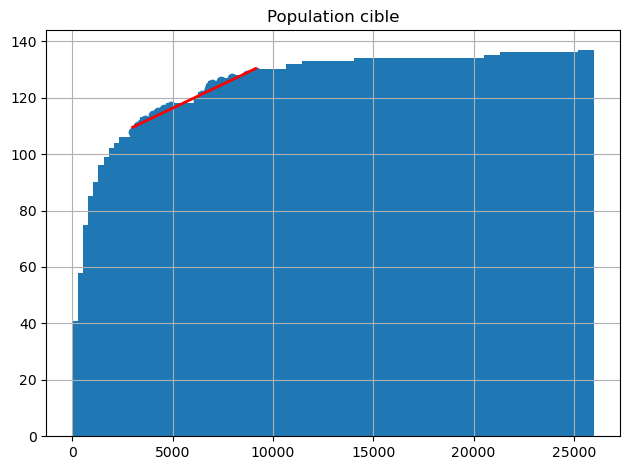

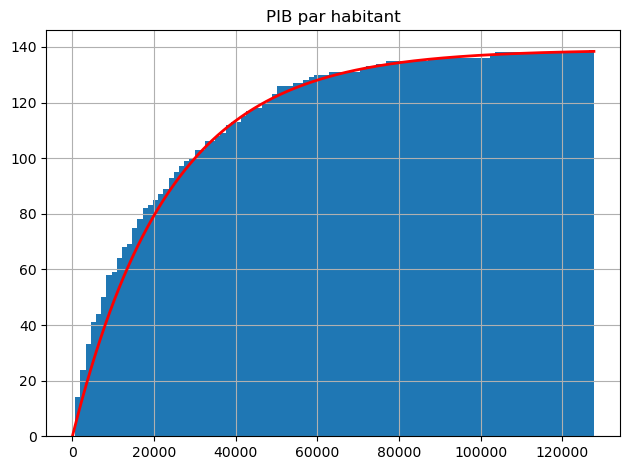

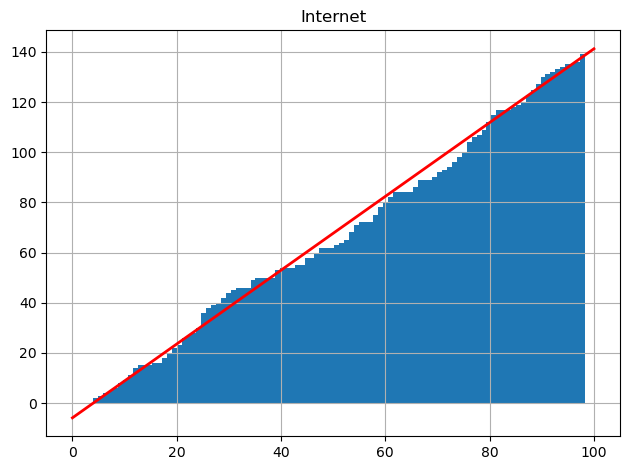


Triple filtrage pour N=20 :
-  Germany

Triple filtrage pour N=30 :
-  Japan
-  Korea, Rep.
-  Germany
-  United Kingdom
-  France
-  Spain
-  Canada


In [13]:
# Données statistiques du jeu de données dataMission
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(dataMission.describe())

# Analyse de seuil de la variable "Population cible"
# Mise en évidence de valeurs atypiques (outliers)
sample = pd.DataFrame([])
sample["X"] = dataMission["Population cible"].sort_values()
print(sample.head(), sample.tail())

# Graphique population cible
plt.hist(dataMission["Population cible"], range=(0, 26000), bins=100, cumulative=True)

# Courbe de régression linéaire sur la partie droite de la courbe entre 3000 et 10000
sample.reset_index(drop=True, inplace=True)
sample["X"] = sample[(sample["X"] >= 3000) & (sample["X"] <= 10000)]
sample["Y"] = pd.DataFrame(sample["X"].index.values)
sample = sample.dropna()
X = np.array(sample["X"]).reshape(-1, 1)
Y = sample["Y"]
lr = LinearRegression(copy_X=True, fit_intercept=True)
lr.fit(X, Y)
r2 = lr.score(X,Y)
YPred = lr.predict(X)
# Affichage des paramètres de la régression et tracé de la droite
print(f"\nRégression linéaire Y = m X + p entre Y={Y.index.values[0]:.0f} et Y={Y.index.values[-1]:.0f} :")
print(f"- Coefficient directeur m = {lr.coef_[0]:.4f}")
print(f"- Ordonnée à l'origine p = {lr.intercept_:.0f}")
print(f"- Coefficient de corrélation R² = {r2:.4f}")
plt.scatter(X, Y)
plt.plot(X, YPred, color='red', linewidth=2.0, label='régression linéaire')

# Affichage du graphique
plt.title("Population cible")
plt.grid()
plt.tight_layout()
plt.savefig("Figure - Variable population cible.png", dpi=150)
plt.show()


# Analyse de seuil de la variable "PIB par habitant"
# Tracé de l'histogramme cumulatif
plt.hist(dataMission["PIB par habitant"], bins=100, cumulative=True)

# Tracé de la courbe exponentielle inversée d'approximation
variance = 23616.0
nbPoints= 1000
domaine = np.linspace(0, 127764, nbPoints)
pop = np.array([139 * (1 - exp(-(x / variance))) for x in domaine])
plt.plot(domaine, pop, color='red', linewidth=2.0)

# Affichage du graphique
plt.title("PIB par habitant")
plt.grid()
plt.tight_layout()
plt.savefig("Figure - Variable PIB par habitant.png", dpi=150)
plt.show()


# Analyse de seuil de la variable  "Internet"
# Tracé de l'histogramme cumulatif
plt.hist(dataMission["Internet"], bins=100, cumulative=True)

# Tracé de la droite d'approximation (min= 4 et max=98)
m = 139 / (98.24-3.76)
p = -m * 4
nbPoints= 100
domaine = np.linspace(0.0, 100.0, nbPoints)
iT = np.array([m * x + p for x in domaine])
plt.plot(domaine, iT, color='red', linewidth=2.0)

# Affichage du graphique
plt.title("Internet")
plt.grid()
plt.tight_layout()
plt.savefig("Figure - Variable internet.png", dpi=150)
plt.show()

# Filtrage sur les 3 valeurs de seuil
# Nombre de pays filtrés par seuil N=20
selectedData = dataMission[(dataMission["Population cible"] >= 5600)
                           & (dataMission["PIB par habitant"] >= 45000)
                           & (dataMission["Internet"] >= 84)]
print("\nTriple filtrage pour N=20 :")
for pays in selectedData["Pays"].tolist():
    print("- ", pays)

# Nombre de pays filtrés par seuil N=30
selectedData = dataMission[(dataMission["Population cible"] >= 2600)
                           & (dataMission["PIB par habitant"] >= 35000)
                           & (dataMission["Internet"] >= 77)]
print("\nTriple filtrage pour N=30 :")
for pays in selectedData["Pays"].tolist():
    print("- ", pays)

<a id="analyse_combo_var"></a>
## Analyse combinée de plusieurs variables
Dans un premier temps, nous examinons les variables 2 à 2 avec la fonction *pairplot* de *seaborn*.
**Nous pouvons constater qu'il n'y a pas de lien entre la variable de population cible et les deux autres.**

En revanche, nous constatons un lien entre les variables <font color='green'>PIB</font> par habitant (notée "<font color='green'>PIB</font>" dans la formule ci-après) et <font color='green'>Internet</font> (notée "<font color='green'>IT</font>" dans la formule ci-après), que nous avions indirectement mis en évidence dans la section précédente :
Cumul nombre de pays = 139 (1 - exp(-$\lambda$PIB)) = m * IT + p, avec une corrélation de type exponentielle.

Nous fixons dès lors un seuil de <font color='green'>50%</font> sur la variable <font color='green'>Internet</font> afin de rechercher une utilisation significative d'internet, mais sans brider excessivement le filtrage.
Deux paires de valeurs de seuil pour (Population cible, PIB par habitant) sont appliquées :
- <font color='green'>(5 600, 45 000)</font>: 2 pays sont retenus - Allemagne et USA
- <font color='green'>(2 600, 30 000)</font>: 8 pays supplémentaires - Japon, Corée, Royaume-Uni, France, Italie, Espagne, Arabie Saoudite et Canada.

En complément, nous traçons **2 graphiques par région** montrant l'**accessibilité** (PIB par habitant) sur l'axe horizontal et la **taille du marché** (Population cible):
- le premier montrant l'ensemble des pays (quel que soit le % d'utilisation d'internet) ;
- le second correspondant au dernier filtrage ci-dessus <font color='green'>(2 600, 20 000)</font>, ce niveau de PIB par habitant correspondant à un taux d'utilisation d'internet supérieur à <font color='green'>50%</font>.

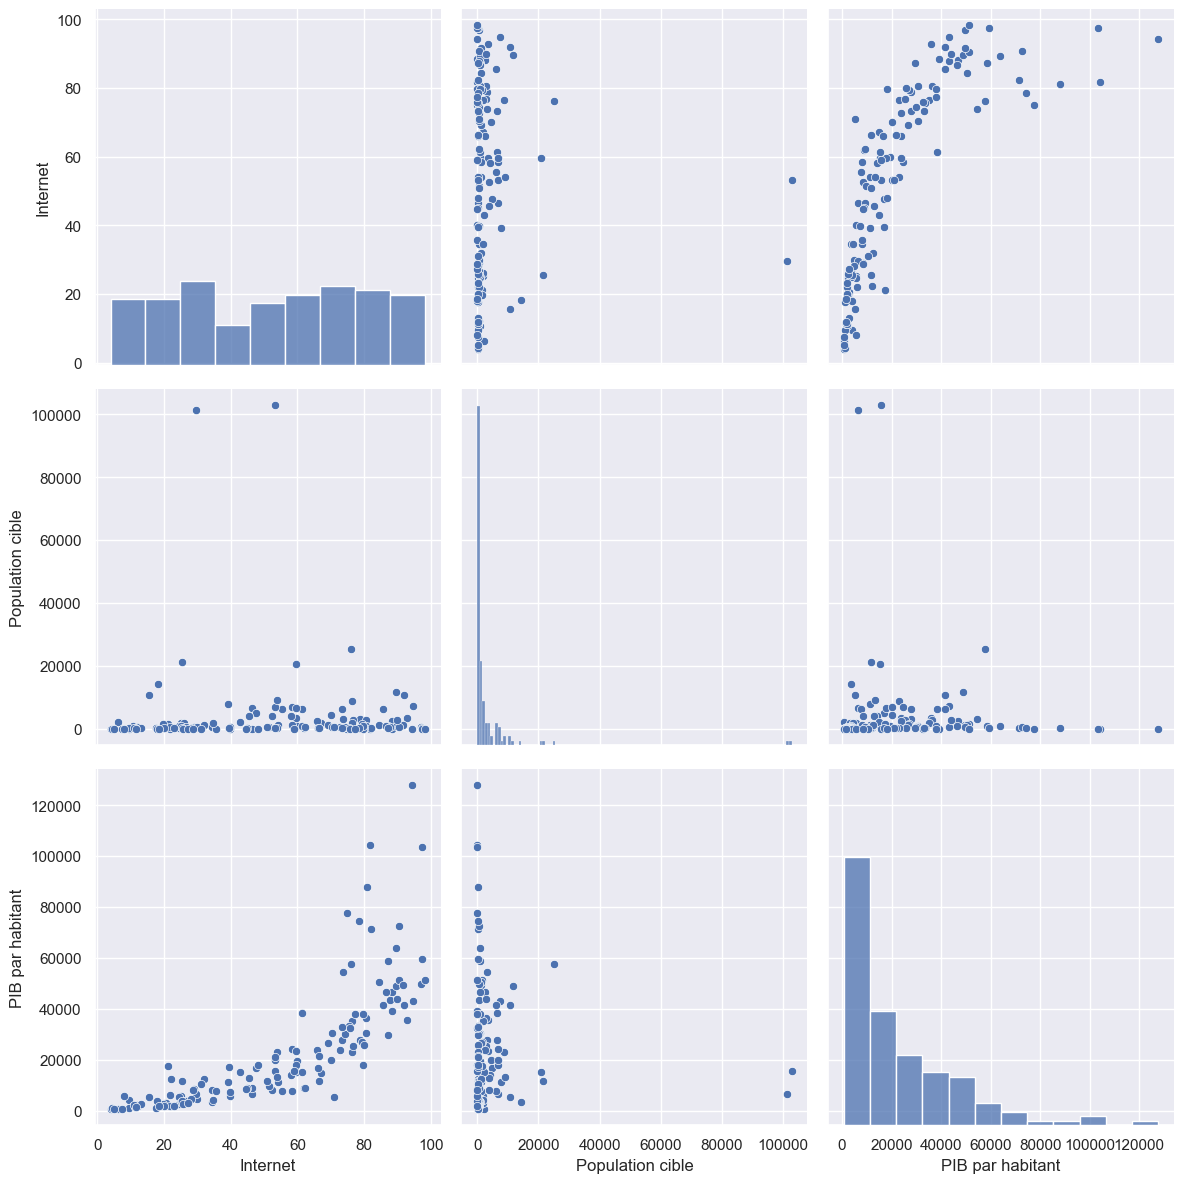


Filtrage sur Population cible > 5600 et PIB par habitant > 45000 : 
-  Germany
-  United States
['Germany', 'United States']

Pays supplémentaires avec Population cible > 2600 et PIB par habitant > 30000 : 
-  Japan
-  Korea, Rep.
-  United Kingdom
-  Italy
-  France
-  Spain
-  Saudi Arabia
-  Canada


In [14]:
# Fixation des paramètres graphiques
sns.set()
#plt.style.use('seaborn-whitegrid')
sns.set_theme()

# Tracé graphique par paire de variable
sns.pairplot(data=dataMission, height=4)
plt.tight_layout()
plt.savefig("Figure - Variables par pairplot.png", dpi=150)
#sns.pairplot(data=dataMission, hue="Region", height=4)
#sns.jointplot(data=dataMission, x="Internet", y="PIB par habitant", kind="reg", marginal_kws=dict(bins=20, fill=True))
#sns.jointplot(data=dataMission, x="PIB par habitant", y="Population cible", kind="reg", marginal_kws=dict(bins=20, fill=True))
plt.show()

# Sensibilité du filtrage sur les 2 variables "Population cible" et "PIB par habitant"
# en fixant le seuil de la variable "Internet" à 50%
selectedData = dataMission[(dataMission["Population cible"] >= 5600)
                           & (dataMission["PIB par habitant"] >= 45000)
                           & (dataMission["Internet"] >= 50)]
print("\nFiltrage sur Population cible > 5600 et PIB par habitant > 45000 : ")
listePays = []
for pays in selectedData["Pays"].tolist():
    print("- ", pays)
    listePays.append(pays)
print(listePays)

selectedData = dataMission[(dataMission["Population cible"] >= 2600)
                           & (dataMission["PIB par habitant"] >= 30000)
                           & (dataMission["Internet"] >= 50)]
print("\nPays supplémentaires avec Population cible > 2600 et PIB par habitant > 30000 : ")
for pays in selectedData["Pays"].tolist():
    if pays not in listePays:
        print("- ", pays)
        listePays.append(pays)

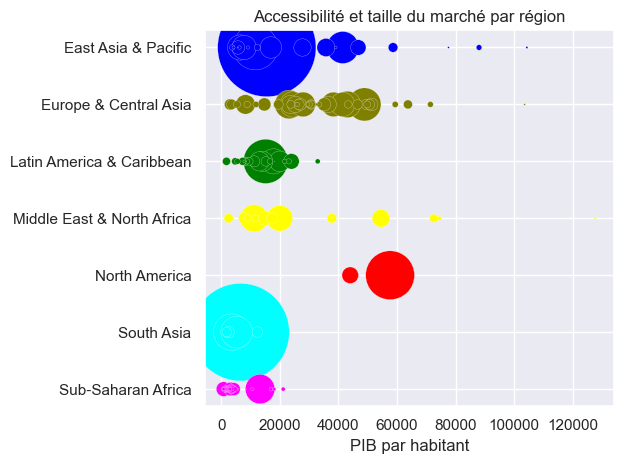

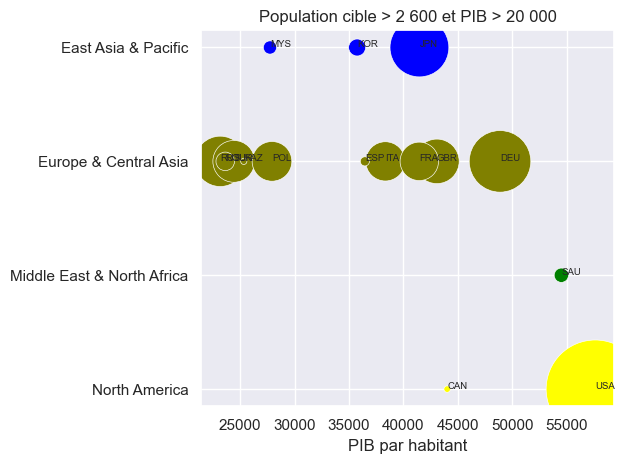

In [15]:
palette = ['blue', 'olive', 'green', 'yellow', 'red', 'cyan', 'magenta', 'darkgoldenrod', 'orange', 'grey']

# Affichage graphique total par région
dataResult = pd.DataFrame(dataMission)
groups = dataResult.groupby("Region")
colorTable = palette[0:len(groups)]
sns.scatterplot(x="PIB par habitant", y="Region", hue="Region", size="Population cible", sizes=(0, 5000),
                palette = colorTable, data=dataResult, legend=False)
plt.title("Accessibilité et taille du marché par région")
plt.ylabel("")
plt.tight_layout()
plt.savefig("Figure - Accessibilité et taille du marché par région.png", dpi=150)
plt.show()

# Affichage graphique des données (selectedData) filtrées par région
selectedData = dataMission[(dataMission["Population cible"] >= 2600)
                           & (dataMission["PIB par habitant"] >= 20000)]
dataResult = pd.DataFrame(selectedData)
# Chargement d'une palette de couleurs de la taille du nombre de régions
groups = dataResult.groupby("Region")
colorTable = palette[0:len(groups)]
# Tracé du diagramme à bulles
ax = sns.scatterplot(x="PIB par habitant", y="Region", hue="Region", size="Population cible",
                     sizes=(20, 5000), palette = colorTable, data=dataResult, legend=False)
# Affichage des codes pays comme étiquette des bulles
labels = pd.DataFrame([])
labels.index = dataResult.index
labels["Labels"] = dataResult.index.values
for line in range(0,dataResult.shape[0]):
    ax.text(dataResult["PIB par habitant"][line]+0.01, dataResult["Region"][line],
            labels["Labels"][line], horizontalalignment='left', size='xx-small')
# Définition du titre, label des axes, sauvegarde dans un fichier et affichage
plt.title("Population cible > 2 600 et PIB > 20 000")
plt.ylabel("")
plt.tight_layout()
plt.savefig("Figure - Filtrage par population cible et PIB.png", dpi=150)
plt.show()

<a id="aconstruc_score"></a>
## Proposition d'un score d'attractivité par pays
Déterminer un score d'attractivité par pays présente l'intérêt de ne pas filtrer *a priori* et donc de conserver tous les pays plutôt qu'en éliminer un nombre non maitrisé. Le tri par le score permet de fixer la liste des pays prioritaires en fonction du nombre que l'on souhaite retenir.
Dès lors, nous pouvons introduire plusieurs clés de tri, par exemple un tri par région avant le tri par le score, ce qui permet une approche stratégique régionalisée.

Le score proposé consiste à faire le produit des 3 variables, car notre objectif est de maximiser les valeurs de chacune de ces variables: <font color='green'>score = Population cible * PIB par habitant * Internet</font>
Nous ajoutons en conséquence à notre DataFrame <font color='green'>dataMission</font> une colonne où est calculé le <font color='green'>score</font>, puis nous en effectuons le tri par valeurs décroissantes de ce score de deux manières :
 - **Tri par pays** : l'affichage des N premiers pays s'effectue avec <font color='green'>dataMission.head(N)</font> ;
 - **Tri par région puis par pays** de la même manière.

Représentation graphique avec un graphe à bulle :
- l'axe horizontal indique le score du pays ;
- les régions sont distribuées sur l'axe vertical ;
- la taille de la bulle indique la population cible.

Liste des 10 pays de plus fort score :
 Indicator Code                     Region                Pays   Score  \
Country Code                                                            
USA                         North America       United States 110,981   
CHN                   East Asia & Pacific               China  85,080   
DEU                 Europe & Central Asia             Germany  51,044   
JPN                   East Asia & Pacific               Japan  41,477   
GBR                 Europe & Central Asia      United Kingdom  30,337   
FRA                 Europe & Central Asia              France  22,193   
IND                            South Asia               India  19,693   
BRA             Latin America & Caribbean              Brazil  18,795   
RUS                 Europe & Central Asia  Russian Federation  15,440   
ITA                 Europe & Central Asia               Italy  15,044   

Indicator Code  Population cible  PIB par habitant  Internet  
Country Code        

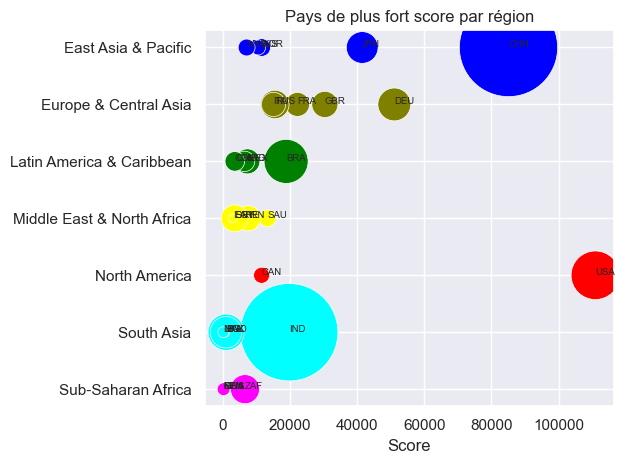

In [16]:
# Préparation des vecteurs à multiplier pour calculer le score
dataMPop = pd.DataFrame(dataMission["Population cible"])
dataMPop.index = dataMission.index
dataMPop.rename(columns={"Population cible": "score"}, inplace=True)
dataMPIB = pd.DataFrame(dataMission["PIB par habitant"])
dataMPIB.index = dataMission.index
dataMPIB.rename(columns={"PIB par habitant": "score"}, inplace=True)
dataMIt = pd.DataFrame(dataMission["Internet"])
dataMIt.index = dataMission.index
dataMIt.rename(columns={"Internet": "score"}, inplace=True)
# Calcul du score
dataScore = dataMPop.mul(dataMPIB, axis=1)
dataScore = dataScore.mul(dataMIt, axis=1)
# Ajout du score dans une nouvelle colonne de dataMission avec recalibration
dataMission["Score"] = dataScore / 1000000
dataMission = dataMission.reindex(["Region", "Pays", "Score", "Population cible", "PIB par habitant", "Internet"],
                                  axis="columns")

# Affichage de la liste de N=10 pays, triés par score décroissant
N = 10
dataMission.sort_values(by="Score", ascending=False, inplace=True)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("Liste des", N,"pays de plus fort score :\n", dataMission.head(10))

# Affichage de la liste de N=5 pays par région, triés par score décroissant
N = 5
dataMission.sort_values(by=["Region", "Score"], ascending=(True, False), inplace=True)
dataResult = pd.DataFrame([])
groups = dataMission.groupby("Region")
for group in groups:
    #dataResult = pd.DataFrame(dataMission[dataMission["Region"]==group[0]].head(N))
    #dataResult = dataResult.append(dataMission[dataMission["Region"]==group[0]].head(N))
    dataResult = pd.concat([dataResult, dataMission[dataMission["Region"]==group[0]].head(N)])
print('\n', dataResult.shape)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("\nListe des", N, "pays de plus fort score pour chacune des", dataResult.shape[1]+1, "régions : \n\n",
          dataResult)
dataResult.to_csv(dossier + "\\" + "dataResult.csv", sep=',')
dataResult.to_csv(dossier + "\\" + "dataResult_xl.csv", sep=';')

# Affichage graphique par région
colorTable = palette[0:len(groups)]
ax = sns.scatterplot(x="Score", y="Region", hue="Region", size="Population cible", sizes=(0, 5000),
                     palette = colorTable, data=dataResult, legend=False)

# Affichage des codes pays comme étiquette des bulles
labels = pd.DataFrame([])
labels.index = dataResult.index
labels["Labels"] = dataResult.index.values
for line in range(0,dataResult.shape[0]):
    ax.text(dataResult["Score"][line]+0.01, dataResult["Region"][line],
            labels["Labels"][line], horizontalalignment='left', size='xx-small')

plt.title("Pays de plus fort score par région")
plt.ylabel("")
plt.tight_layout()
plt.savefig("Figure - Score par région.png", dpi=150)
plt.show()

<a id="alt_score"></a>
## Analyse du score d'attractivité avec le jeu de données projetées
S'agissant des 10 pays de plus fort score:
- Le résultat est le même pour les 9 premiers pays et le 10$^{ème}$, l'Italie, est remplacée par l'Arabie Saoudite.
- La Chine prend la première position à la place des USA.

S'agissant des résultats par région :
- Asie de l'Est et pacifique : la Malaisie est remplacée en 5$^{ème}$ position par l'Indonésie.
- Europe et Asie centrale : pas de changement.
- Amérique latine : pas de changement.
- Moyen-Orient et Afrique du Nord : pas de changement si ce n'est l'inversion de l'Egypte et des Emirats Arabes Unis pour les 3$^{ème}$ et 4$^{ème}$ positions.
- Amérique du Nord : pas de changement.
- Asie du Sud : pas de changement.
- Afrique sub-Saharienne : pas de changement.

Au total, **la cible des pays les plus adaptés à un développement commercial n'est quasiment pas impactée par le jeu de données prévisionnelles**.

Liste des 10 pays de plus fort score :
 Indicator Code                      Region                Pays   Score  \
Country Code                                                             
CHN                    East Asia & Pacific               China 145,670   
USA                          North America       United States 116,712   
DEU                  Europe & Central Asia             Germany  62,032   
JPN                    East Asia & Pacific               Japan  48,317   
GBR                  Europe & Central Asia      United Kingdom  33,947   
IND                             South Asia               India  28,884   
FRA                  Europe & Central Asia              France  28,367   
BRA              Latin America & Caribbean              Brazil  27,923   
RUS                  Europe & Central Asia  Russian Federation  26,249   
SAU             Middle East & North Africa        Saudi Arabia  19,078   

Indicator Code  Population cible  PIB par habitant  Internet  
Country 

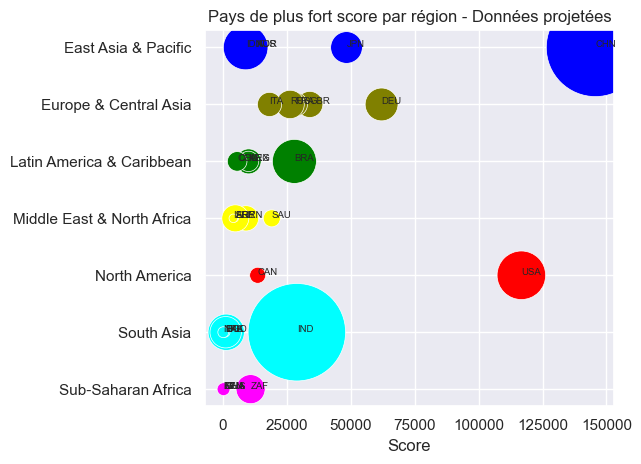

In [17]:
# Préparation des vecteurs à multiplier pour calculer le score (même label de colonne)
dataMPop = pd.DataFrame(dataMissionProj["Population cible"])
dataMPop.index = dataMissionProj.index
dataMPop.rename(columns={"Population cible": "score"}, inplace=True)
dataMPIB = pd.DataFrame(dataMissionProj["PIB par habitant"])
dataMPIB.index = dataMissionProj.index
dataMPIB.rename(columns={"PIB par habitant": "score"}, inplace=True)
dataMIt = pd.DataFrame(dataMissionProj["Internet"])
dataMIt.index = dataMissionProj.index
dataMIt.rename(columns={"Internet": "score"}, inplace=True)
# Calcul du score
dataScore = dataMPop.mul(dataMPIB, axis=1)
dataScore = dataScore.mul(dataMIt, axis=1)
# Ajout du score dans une nouvelle colonne de dataMission avec recalibration
dataMissionProj["Score"] = dataScore / 1000000
dataMissionProj = dataMissionProj.reindex(["Region", "Pays", "Score", "Population cible", "PIB par habitant", "Internet"],
                                           axis="columns")

# Affichage de la liste de N=10 pays, triés par score décroissant
N = 10
dataMissionProj.sort_values(by="Score", ascending=False, inplace=True)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("Liste des", N,"pays de plus fort score :\n", dataMissionProj.head(10))

# Affichage de la liste de N=5 pays par région, triés par score décroissant
N = 5
dataMissionProj.sort_values(by=["Region", "Score"], ascending=(True, False), inplace=True)
dataResult = pd.DataFrame([])
groups = dataMissionProj.groupby("Region")
for group in groups:
    #dataResult = pd.DataFrame(dataMissionProj[dataMissionProj["Region"]==group[0]].head(N))
    #dataResult = dataResult.append(dataMissionProj[dataMissionProj["Region"]==group[0]].head(N))
    dataResult = pd.concat([dataResult, dataMissionProj[dataMissionProj["Region"]==group[0]].head(N)])
print('\n', dataResult.shape)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print("\nListe des", N, "pays de plus fort score pour chacune des", dataResult.shape[1]+1, "régions : \n\n",
          dataResult)
dataResult.to_csv(dossier + "\\" + "dataResultProj.csv", sep=',')
dataResult.to_csv(dossier + "\\" + "dataResultProj_xl.csv", sep=';')

# Affichage graphique par région
colorTable = palette[0:len(groups)]
ax = sns.scatterplot(x="Score", y="Region", hue="Region", size="Population cible", sizes=(0, 5000),
                     palette = colorTable, data=dataResult, legend=False)

# Affichage des codes pays comme étiquette des bulles
labels = pd.DataFrame([])
labels.index = dataResult.index
labels["Labels"] = dataResult.index.values
for line in range(0,dataResult.shape[0]):
    ax.text(dataResult["Score"][line]+0.01, dataResult["Region"][line],
            labels["Labels"][line], horizontalalignment='left', size='xx-small')

plt.title("Pays de plus fort score par région - Données projetées")
plt.ylabel("")
plt.tight_layout()
plt.savefig("Figure - Score par région - Données projetées.png", dpi=150)
plt.show()

<a id="conclusion"></a>
# Conclusion
Dans cette étude, nous avons analysé les données “EdStats All Indicator Query” de la Banque mondiale afin d'identifier les indicateurs pertinents et constituer en conséquence un jeu de données à exploiter. Puis, nous avons analysé ce jeu de donnée afin d'examiner plusieurs approches permettant d'identifier les pays les plus adaptés à un développement commercial.

Les indicateurs pertinents retenus :
- le volume de population cible ;
- le PIB par habitant ;
- le % d'utilisateurs d'internet.

Le volume de population cible (en milliers) a été déduit à partir de 16 indicateurs donnant, par tranche de 5 ans d'age de 20 à 59 ans, le volume de la population et le % de personnes ayant terminé leurs études secondaires. Il a de plus été tenu compte, pour chacune de ces tranches d'age, d'un coefficient de besoin et capacité à recourir à de la formation (en % du volume de population de la tranche considérée). Ces coefficients sont des paramètres à ajuster avec le board de l'entreprise afin de refléter sa stratégie de ciblage des étudiants. La construction et le paramétrage de cet indicateur sont explicités à la section "[présélection des indicateurs](#ps_var)".

En fonction des données disponibles, ces indicateurs sont renseignés pour 140 pays, les pays de taille significative étant représentés.

L'analyse des indicateurs montre que le marché peut être représenté sur un graphe à 2 dimensions et structuré par région :
- l'**accessibilité au marché** (position en abscisse) donnée par l'indicateur **PIB par habitant** ou **% d'utilisateurs d'internet**, ces deux variables étant liées ;
- le **volume de marché** selon la **population cible** (taille de la bulle) ;
- une **représentation structurée par région** (différents niveaux de l'axe des ordonnées) mais qui permet également de lire le palmarès par pays.

**Au final, les analyses présentées permettront de soutenir une présentation au board de l'entreprise afin de souligner les points clés et acter les orientations à prendre pour poursuivre plus avant cette analyse.**